In [1]:

import math
import pandas as pd
import numpy as np
import datetime

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from pandas_datareader import data as pdr
import fix_yahoo_finance as yf

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl

mpl.rc('figure', figsize=(8, 7))
style.use('ggplot')

print("Good to go.")

Good to go.


In [4]:
# Now, lets get some data.

def get_historical_data(symbol, start_date="2019-01-01"):
  yf.pdr_override()
  df = pdr.get_data_yahoo(symbol, start=start_date).reset_index()
  df.to_csv(symbol + '.csv', index=False)
  
get_historical_data('JPM')

print("Data acquired!")

[*********************100%***********************]  1 of 1 downloaded
Data acquired!


In [5]:


df = pd.read_csv('JPM.csv');
df = df.loc[:, ['Date', 'Volume', 'Open', 'High', 'Low', 'Close', 'Adj Close']]

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.sort_values(by=['Date'], ascending=[True])
df.set_index('Date', inplace=True)
df = df.resample('D').fillna(method=None).interpolate()

df.head()

,Volume,Open,High,Low,Close,Adj Close
Date,,,,,,
2019-01-02,15670900.0,95.949997,99.779999,95.940002,99.309998,96.303230
2019-01-03,16286400.0,98.639999,98.889999,96.690002,97.110001,94.934593
2019-01-04,16935200.0,99.110001,100.930000,98.279999,100.690002,98.434395
2019-01-05,16433700.0,99.550001,101.110000,98.756666,100.713335,98.457207
2019-01-06,15932200.0,99.990000,101.290001,99.233332,100.736669,98.480019


Next, we'll calculate the price changes to engineer extra features.


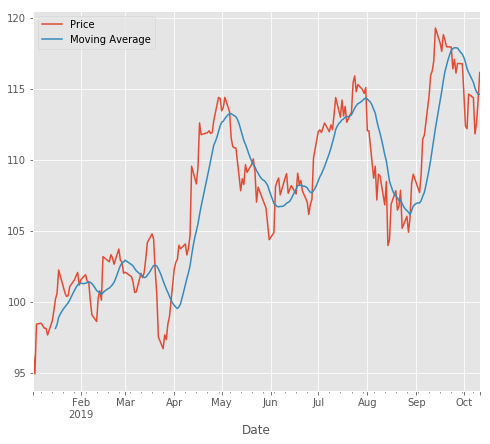

In [6]:
print("Next, we'll calculate the price changes to engineer extra features.")

# Calculate moving average
ma_window = 15
df['MA'] = df['Adj Close'].rolling(window=ma_window).mean()
df['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
df['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

df['Adj Close'].plot(label='Price')
df['MA'].plot(label='Moving Average')
plt.legend()

In [7]:
# Now, it's time for preprocessing & cross-validation!

# Drop missing value
df.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(df)))

# Separating the label here, we want to predict the Forecast value
df['Label'] = df['Adj Close'].shift(-forecast_out)
X = np.array(df.drop(['Label'], axis=1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(df['Label'])
y = y[:-forecast_out]

df.head()

,Volume,Open,High,Low,Close,Adj Close,MA,HL_PCT,PCT_change,Label
Date,,,,,,,,,,
2019-01-02,15670900.0,95.949997,99.779999,95.940002,99.309998,96.303230,-99999.0,3.866677,3.501825,98.457207
2019-01-03,16286400.0,98.639999,98.889999,96.690002,97.110001,94.934593,-99999.0,2.265469,-1.551093,98.480019
2019-01-04,16935200.0,99.110001,100.930000,98.279999,100.690002,98.434395,-99999.0,2.631841,1.594189,98.502831
2019-01-05,16433700.0,99.550001,101.110000,98.756666,100.713335,98.457207,-99999.0,2.336666,1.168593,98.317078
2019-01-06,15932200.0,99.990000,101.290001,99.233332,100.736669,98.480019,-99999.0,2.041628,0.746743,98.150894


In [8]:

# So, how'd we do?

# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X, y)
clfreg_confidence = clfreg.score(X, y) * 100
print('Linear regression score: {:.2f}%'.format(clfreg_confidence))

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X, y)
clfpoly2_confidence = clfpoly2.score(X, y) * 100
print('Quadratic Regression 2 score: {:.2f}%'.format(clfpoly2_confidence))

# Quadratic Regression 5
clfpoly5 = make_pipeline(PolynomialFeatures(5), Ridge())
clfpoly5.fit(X, y)
clfpoly5_confidence = clfpoly5.score(X, y) * 100
print('Quadratic Regression 5 score: {:.2f}%'.format(clfpoly5_confidence))

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X, y)
clfknn_confidence = clfknn.score(X, y) * 100
print('KNN Regression score: {:.2f}%'.format(clfknn_confidence))

Linear regression score: 90.59%
Quadratic Regression 2 score: 90.98%
Quadratic Regression 5 score: 96.18%
KNN Regression score: 94.28%


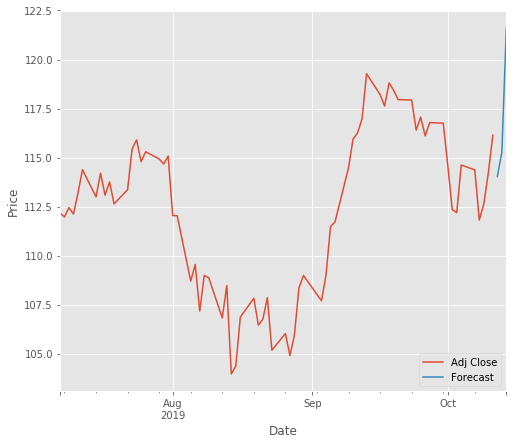

In [9]:

clfreg_forecast = clfreg.predict(X_lately)
clfpoly2_forecast = clfpoly2.predict(X_lately)
clfpoly5_forecast = clfpoly5.predict(X_lately)
clfknn_forecast = clfknn.predict(X_lately)
forecast_set = (clfreg_forecast + clfpoly2_forecast + clfpoly5_forecast + clfknn_forecast) / 4

df['Forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    df.loc[next_date] = [np.nan for _ in
                         range(len(df.columns)-1)]+[i]

df['Adj Close'].tail(100).plot()
df['Forecast'].tail(100).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [10]:
isBuySignal = np.mean(forecast_set) > df.iloc[-forecast_set.size - 1]['Adj Close']

print('I think you should...')
print('BUY!' if isBuySignal else 'SELL!')

I think you should...
BUY!


In [0]:
from collections import deque
import random

name = 'Double Q-learning agent'

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate):
        self.X = tf.placeholder(tf.float32, (None, input_size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        feed_forward = tf.layers.dense(self.X, layer_size, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, output_size)
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self):
        for i in range(len(self.trainable)//2):
            assign_op = self.trainable[i+len(self.trainable)//2].assign(self.trainable[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.predict(states)
        Q_new = self.predict(new_states)
        Q_new_negative = self.sess.run(self.model_negative.logits, feed_dict={self.model_negative.X:new_states})
        replay_size = len(replay)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, done_r = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not done_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
        return X, Y

    def predict(self, inputs):
        return self.sess.run(self.model.logits, feed_dict={self.model.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign()
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                state = next_state
                X, Y = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [12]:
import tensorflow as tf

df_full = pdr.get_data_yahoo("JPM", start="2017-01-01").reset_index()
close = df_full['Close'].values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

[*********************100%***********************]  1 of 1 downloaded
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
epoch: 10, total rewards: 328.769969.3, cost: 0.071548, total money: 9987.559970
epoch: 20, total rewards: 25.210047.3, cost: 0.111893, total money: 6985.050049
epoch: 30, total rewards: -36.210029.3, cost: 0.027126, total money: 9025.199959
epoch: 40, total rewards: 227.899947.3, cost: 0.031514, total money: 8957.739935
epoch: 50, total rewards: 110.200029.3, cost: 0.001927, total money: 9883.360033
epoch: 60, total rewards: -23.050000.3, cost: 0.017762, total money: 9976.950000
epoch: 70, total rewards: 85.900001.3, cost: 0.011271, total money: 9746.870003
epoch: 80, total rewards: 39.459954.3, cost: 0.008163, total money: 9812.619958
epoch: 90, total rewards: -57.939995.3, cost: 0.003213, total money: 9942.060005
epoch: 100, total rewards: -22.830008.3, cost: 0.009602, total money: 9977

In [13]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 8: buy 1 unit at price 86.699997, total balance 9913.300003
day 9: buy 1 unit at price 83.550003, total balance 9829.750000
day 10: buy 1 unit at price 83.940002, total balance 9745.809998
day 11: buy 1 unit at price 83.300003, total balance 9662.509995
day 12, sell 1 unit at price 83.669998, investment -3.494809 %, total balance 9746.179993,
day 13: buy 1 unit at price 83.709999, total balance 9662.469994
day 14, sell 1 unit at price 84.720001, investment 1.400357 %, total balance 9747.189995,
day 15, sell 1 unit at price 86.029999, investment 2.489870 %, total balance 9833.219994,
day 16, sell 1 unit at price 86.750000, investment 4.141653 %, total balance 9919.969994,
day 17: buy 1 unit at price 86.930000, total balance 9833.039994
day 18, sell 1 unit at price 86.029999, investment 2.771473 %, total balance 9919.069993,
day 19, sell 1 unit at price 84.629997, investment -2.645810 %, total balance 10003.699990,
day 24: buy 1 unit at price 86.720001, total balance 9916.979989
day 

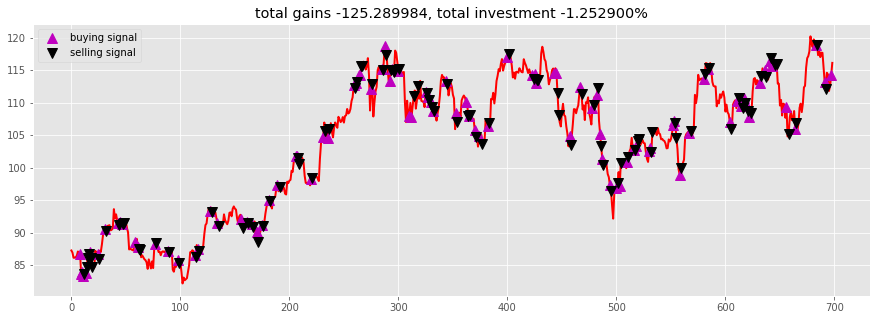

In [14]:

fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()